In [1]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

%matplotlib inline

2025-09-25 11:18:12.349613: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-25 11:18:12.349865: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-25 11:18:12.381737: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-25 11:18:13.183767: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation or

# Helpers

In [2]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test
def adf_test(df, response, alpha=0.05, autolag='AIC'):
    series = pd.to_numeric(df[response], errors='coerce').dropna()

    adf_stat, pval, lags, nobs, crit, _ = adfuller(series, autolag=autolag)

    is_stationary = pval < alpha

    if is_stationary:
        reason = (f'Stationary: ADF p-value={pval:.4g} < {alpha} so reject the null hyptothesis')
    else:
        reason = (f'Non-stationary: ADF p-value={pval:.4g} >= {alpha} so fail to reject the null hypothesis')

    return reason

# RNNs

In [3]:
class ElmanRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, output_dim, activation='tanh', output_activation=None, kernel_init='glorot_uniform', recurrent_init='glorot_uniform', bias_init='zeros', **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)
        self.output_activation = tf.keras.activations.get(output_activation)
        self.kernel_init = tf.keras.initializers.get(kernel_init)
        self.recurrent_init = tf.keras.initializers.get(recurrent_init)
        self.bias_init = tf.keras.initializers.get(bias_init)

        self.state_size = units
        self.output_size = output_dim
        self.supports_masking = True

    def build(self, input_shape):
        input_dim = input_shape[-1]

        self.Wx = self.add_weight(shape=(input_dim, self.units), initializer=self.kernel_init, name='Wx')
        self.Wh = self.add_weight(shape=(self.units, self.units), initializer=self.recurrent_init, name='Wh')
        self.bh = self.add_weight(shape=(self.units,), initializer=self.bias_init, name='bh')

        self.Wo = self.add_weight(shape=(self.units, self.output_dim), initializer=self.kernel_init, name='Wo')
        self.bo = self.add_weight(shape=(self.output_dim,), initializer=self.bias_init, name='bo')

        super().build(input_shape)

    def call(self, inputs, states, training=None):
        h_prev = states[0]

        h_t = tf.matmul(inputs, self.Wx) + tf.matmul(h_prev, self.Wh) + self.bh
        h_t = self.activation(h_t)

        y_t = tf.matmul(h_t, self.Wo) + self.bo

        if self.output_activation is not None:
            y_t = self.output_activation(y_t)

        return y_t, [h_t]

    def get_config(self):
        base = super().get_config()
        base.update({
            "units": self.units,
            "output_dim": self.output_dim,
            "activation": tf.keras.activations.serialize(self.activation),
            "output_activation": tf.keras.activations.serialize(self.output_activation),
            "kernel_initializer": tf.keras.initializers.serialize(self.kernel_init),
            "recurrent_initializer": tf.keras.initializers.serialize(self.recurrent_init),
            "bias_initializer": tf.keras.initializers.serialize(self.bias_init),
        })
        return base


def ElmanRNN(units, output_dim, return_sequences=False, **kwargs):
    cell = ElmanRNNCell(units=units, output_dim=output_dim, **kwargs)
    return tf.keras.layers.RNN(cell, return_sequences=return_sequences)


def build_elman_model(input_dim, units=64, output_dim=1, return_sequences=False, output_activation=None):
    inp = tf.keras.Input(shape=(None, input_dim))
    x = ElmanRNN(units=units, output_dim=output_dim, return_sequences=return_sequences, activation='tanh', output_activation=output_activation)(inp)
    model = tf.keras.Model(inp, x)
    return model

In [4]:
class JordanRNNCell(tf.keras.layers.Layer):

    def __init__(self, units, output_dim, activation='tanh', output_activation=None, kernel_init='glorot_uniform', recurrent_init='glorot_uniform', bias_init='zeros', **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)
        self.output_activation = tf.keras.activations.get(output_activation)
        self.kernel_init = tf.keras.initializers.get(kernel_init)
        self.recurrent_init = tf.keras.initializers.get(recurrent_init)
        self.bias_init = tf.keras.initializers.get(bias_init)

        self.state_size = output_dim
        self.output_size = output_dim
        self.supports_masking = True

    def build(self, input_shape):
        input_dim = input_shape[-1]

        self.Wx = self.add_weight(shape=(input_dim, self.units), initializer=self.kernel_init, name='Wx')
        self.Wy = self.add_weight(shape=(self.output_dim, self.units), initializer=self.recurrent_init, name='Wy')
        self.bh = self.add_weight(shape=(self.units, ), initializer=self.bias_init, name='bh')

        self.Wo = self.add_weight(shape=(self.units, self.output_dim), initializer=self.kernel_init, name='Wo')
        self.bo = self.add_weight(shape=(self.output_dim, ), initializer=self.bias_init, name='bo')

        super().build(input_shape)

    def call(self, inputs, states, training=None):
        y_prev = states[0]

        h_t = tf.matmul(inputs, self.Wx) + tf.matmul(y_prev, self.Wy) + self.bh
        h_t = self.activation(h_t)

        y_t = tf.matmul(h_t, self.Wo) + self.bo

        if self.output_activation is not None:
            y_t = self.output_activation(y_t)
        
        return y_t, [y_t]
    
    def get_config(self):
        base = super().get_config()
        base.update({
            "units": self.units,
            "output_dim": self.output_dim,
            "activation": tf.keras.activations.serialize(self.activation),
            "output_activation": tf.keras.activations.serialize(self.output_activation),
            "kernel_initializer": tf.keras.initializers.serialize(self.kernel_init),
            "recurrent_initializer": tf.keras.initializers.serialize(self.recurrent_init),
            "bias_initializer": tf.keras.initializers.serialize(self.bias_init),
        })
        return base


def JordanRNN(units, output_dim, return_sequences=False, **kwargs):
    cell = JordanRNNCell(units=units, output_dim=output_dim, **kwargs)
    return tf.keras.layers.RNN(cell, return_sequences=return_sequences)


def build_jordan_model(input_dim, units=64, output_dim=1, return_sequences=False, output_activation=None):
    inp = tf.keras.Input(shape=(None, input_dim))
    x = JordanRNN(units=units, output_dim=output_dim, return_sequences=return_sequences, activation='tanh', output_activation=output_activation)(inp)
    model = tf.keras.Model(inp, x)
    return model

In [5]:
class MultiRNNCell(tf.keras.layers.Layer):

    def __init__(self, units, output_dim, activation='tanh', output_activation=None, kernel_init='glorot_uniform', recurrent_init='glorot_uniform', bias_init='zeros', **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.output_dim = output_dim
        self.activation = tf.keras.activations.get(activation)
        self.output_activation = tf.keras.activations.get(output_activation)
        self.kernel_init = tf.keras.initializers.get(kernel_init)
        self.recurrent_init = tf.keras.initializers.get(recurrent_init)
        self.bias_init = tf.keras.initializers.get(bias_init)

        self.state_size = [units, output_dim]
        self.output_size = output_dim
        self.supports_masking = True

    def build(self, input_shape):
        input_dim = input_shape[-1]

        self.Wx = self.add_weight(shape=(input_dim, self.units), initializer=self.kernel_init, name='Wx')
        self.Wh = self.add_weight(shape=(self.units, self.units), initializer=self.recurrent_init, name='Wh')
        self.Wy = self.add_weight(shape=(self.output_dim, self.units), initializer=self.recurrent_init, name='Wy')
        self.bh = self.add_weight(shape=(self.units, ), initializer=self.bias_init, name='bh')

        self.Wo = self.add_weight(shape=(self.units, self.output_dim), initializer=self.kernel_init, name='Wo')
        self.bo = self.add_weight(shape=(self.output_dim, ), initializer=self.bias_init, name='bo')

        super().build(input_shape)

    def call(self, inputs, states, training=None):
        h_prev, y_prev = states

        # takes both
        h_t = tf.matmul(inputs, self.Wx) + tf.matmul(h_prev, self.Wh) + tf.matmul(y_prev, self.Wy) + self.bh
        h_t = self.activation(h_t)

        y_t = tf.matmul(h_t, self.Wo) + self.bo

        if self.output_activation is not None:
            y_t = self.output_activation(y_t)
        
        return y_t, [h_t, y_t]
    
    def get_config(self):
        base = super().get_config()
        base.update({
            "units": self.units,
            "output_dim": self.output_dim,
            "activation": tf.keras.activations.serialize(self.activation),
            "output_activation": tf.keras.activations.serialize(self.output_activation),
            "kernel_initializer": tf.keras.initializers.serialize(self.kernel_init),
            "recurrent_initializer": tf.keras.initializers.serialize(self.recurrent_init),
            "bias_initializer": tf.keras.initializers.serialize(self.bias_init),
        })
        return base

    
def MultiRNN(units, output_dim, return_sequences=False, **kwargs):
    cell = MultiRNNCell(units=units, output_dim=output_dim, **kwargs)
    return tf.keras.layers.RNN(cell, return_sequences=return_sequences)


def build_multi_model(input_dim, units=64, output_dim=1, return_sequences=False, output_activation=None):
    inp = tf.keras.Input(shape=(None, input_dim))
    x = MultiRNN(units=units, output_dim=output_dim, return_sequences=return_sequences, activation='tanh', output_activation=output_activation)(inp)
    model = tf.keras.Model(inp, x)
    return model

# Datasets

## AMD

In [6]:
df_amd = pd.read_csv('data/AMD.csv', parse_dates=['Date'], index_col='Date')
print(df_amd.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10098 entries, 1980-03-17 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10098 non-null  float64
 1   High       10098 non-null  float64
 2   Low        10098 non-null  float64
 3   Close      10098 non-null  float64
 4   Adj Close  10098 non-null  float64
 5   Volume     10098 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 552.2 KB
None


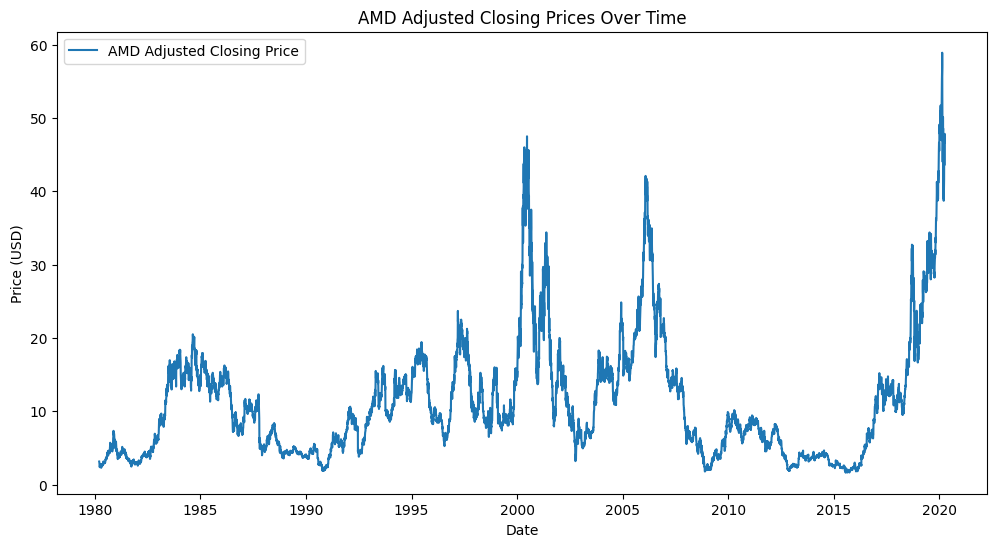

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df_amd['Adj Close'], label='AMD Adjusted Closing Price')
plt.title('AMD Adjusted Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [ ]:
print(adf_test(df_amd, 'Adj Close'))

Non-stationary: ADF p-value=0.05468 >= 0.05 so fail to reject the null hypothesis


## Air Quality

In [22]:
df_air = pd.read_csv('data/AirQualityUCI.csv', sep=';', decimal=',', na_values=[-200, '-200'])
df_air = df_air.loc[:, ~df_air.columns.str.contains("^Unnamed")]
print(df_air.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         7674 non-null   float64
 3   PT08.S1(CO)    8991 non-null   float64
 4   NMHC(GT)       914 non-null    float64
 5   C6H6(GT)       8991 non-null   float64
 6   PT08.S2(NMHC)  8991 non-null   float64
 7   NOx(GT)        7718 non-null   float64
 8   PT08.S3(NOx)   8991 non-null   float64
 9   NO2(GT)        7715 non-null   float64
 10  PT08.S4(NO2)   8991 non-null   float64
 11  PT08.S5(O3)    8991 non-null   float64
 12  T              8991 non-null   float64
 13  RH             8991 non-null   float64
 14  AH             8991 non-null   float64
dtypes: float64(13), object(2)
memory usage: 1.1+ MB
None


In [23]:
ts = pd.to_datetime(
    df_air['Date'].astype(str).str.strip() + ' ' + df_air['Time'].astype(str).str.replace('.', ':', regex=False),
    dayfirst=True,
    errors='coerce'
)

df_air.insert(0, 'timestamp', ts)
df_air = df_air.dropna(subset=['timestamp']).sort_values('timestamp').reset_index(drop=True) # drop bad timestamps
df_air = df_air.set_index('timestamp').sort_index()

df_air = df_air.drop(columns=['Date', 'Time'])

In [24]:
df_air.dropna(subset='CO(GT)')

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
timestamp,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568
2005-04-04 11:00:00,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119
2005-04-04 12:00:00,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406


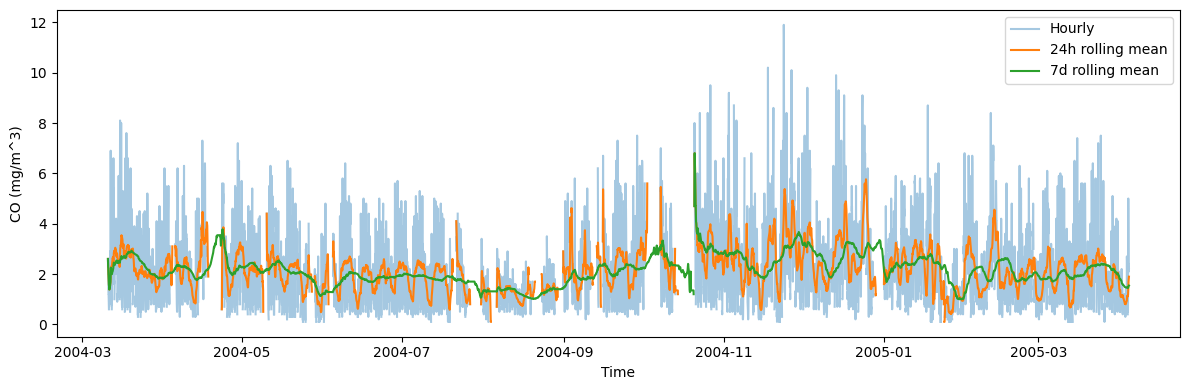

In [ ]:
df_air['CO_24h_mean'] = df_air['CO(GT)'].rolling(24, min_periods=1).mean()
df_air['CO_7d_mean']  = df_air['CO(GT)'].rolling(24*7, min_periods=1).mean()

plt.figure(figsize=(12, 4))
plt.plot(df_air.index, df_air['CO(GT)'], alpha=0.4, label='Hourly')
plt.plot(df_air.index, df_air['CO_24h_mean'], label='24h rolling mean')
plt.plot(df_air.index, df_air['CO_7d_mean'], label='7d rolling mean')
plt.title('Air Quality Over Time')
plt.xlabel('Time')
plt.ylabel('CO (mg/m^3)')
plt.legend()
plt.tight_layout()
# plt.savefig('air_q_over_time.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [26]:
print(adf_test(df_air, 'CO(GT)'))

Stationary: ADF p-value=2.498e-16 < 0.05 so reject the null hyptothesis


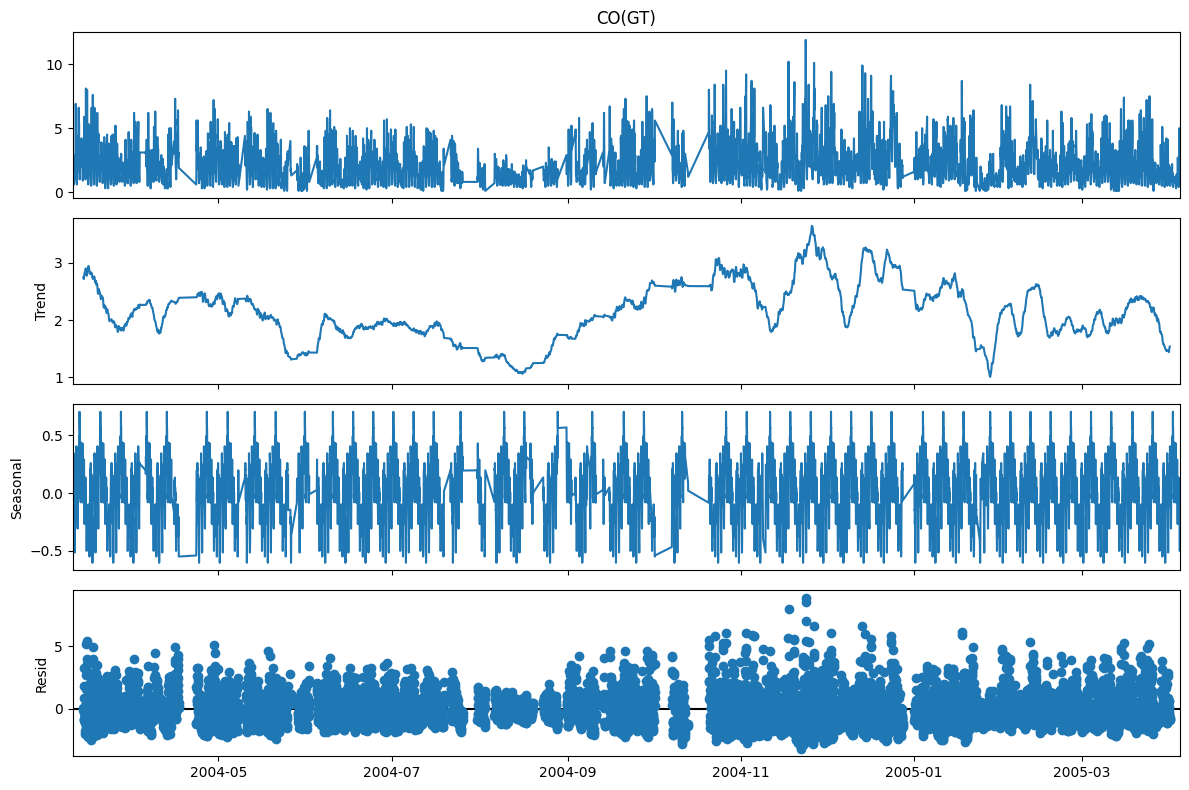

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_air['CO(GT)'].dropna(), model='additive', period=24*7)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
#plt.savefig('air_q_seasonal.pdf', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()